Setup and Library Imports

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
import os
import joblib
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Styling for plots
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

Data Acquisition

In [32]:
url = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.txt"
dataset_path = "KDDTrain+.csv"

if not os.path.exists(dataset_path):
    print("Downloading NSL-KDD Dataset...")
    urllib.request.urlretrieve(url, dataset_path)
    print("Download Complete.")

# NSL-KDD Column Headers
columns = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot",
           "num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creations",
           "num_shells","num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count","srv_count",
           "serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate",
           "dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
           "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate",
           "dst_host_srv_rerror_rate","attack_type","difficulty_level"]

df = pd.read_csv(dataset_path, names=columns)
print(f"Dataset Loaded: {df.shape[0]} rows and {df.shape[1]} columns.")

Dataset Loaded: 125973 rows and 43 columns.


Data Engineering & Multiclass Mapping

In [33]:
# Mapping specific attacks to 5 main categories
attack_mapping = {
    'normal': 0,
    # DoS Attacks
    'neptune': 2, 'back': 2, 'land': 2, 'pod': 2, 'smurf': 2, 'teardrop': 2, 'mailbomb': 2, 'apache2': 2, 'processtable': 2, 'udpstorm': 2,
    # Probe Attacks
    'ipsweep': 1, 'nmap': 1, 'portsweep': 1, 'satan': 1, 'mscan': 1, 'saint': 1,
    # R2L (Remote to Local)
    'ftp_write': 3, 'guess_passwd': 3, 'imap': 3, 'multihop': 3, 'phf': 3, 'spy': 3, 'warezclient': 3, 'warezmaster': 3, 'sendmail': 3, 'named': 3, 'snmpgetattack': 3, 'snmpguess': 3, 'xlock': 3, 'xsnoop': 3, 'worm': 3,
    # U2R (User to Root)
    'buffer_overflow': 4, 'loadmodule': 4, 'perl': 4, 'rootkit': 4, 'sqlattack': 4, 'xterm': 4, 'ps': 4
}

df['label'] = df['attack_type'].map(attack_mapping).fillna(0).astype(int)
df['proto_num'] = df['protocol_type'].map({'tcp': 6, 'udp': 17, 'icmp': 1}).fillna(0)

# Feature Selection: Choosing features capturable in a live network environment
# 'src_bytes' maps to packet length, 'count' maps to traffic density
X = df[['src_bytes', 'proto_num', 'count', 'srv_count']].rename(columns={'src_bytes': 'length'})
y = df['label']

Exploratory Data Analysis (EDA)

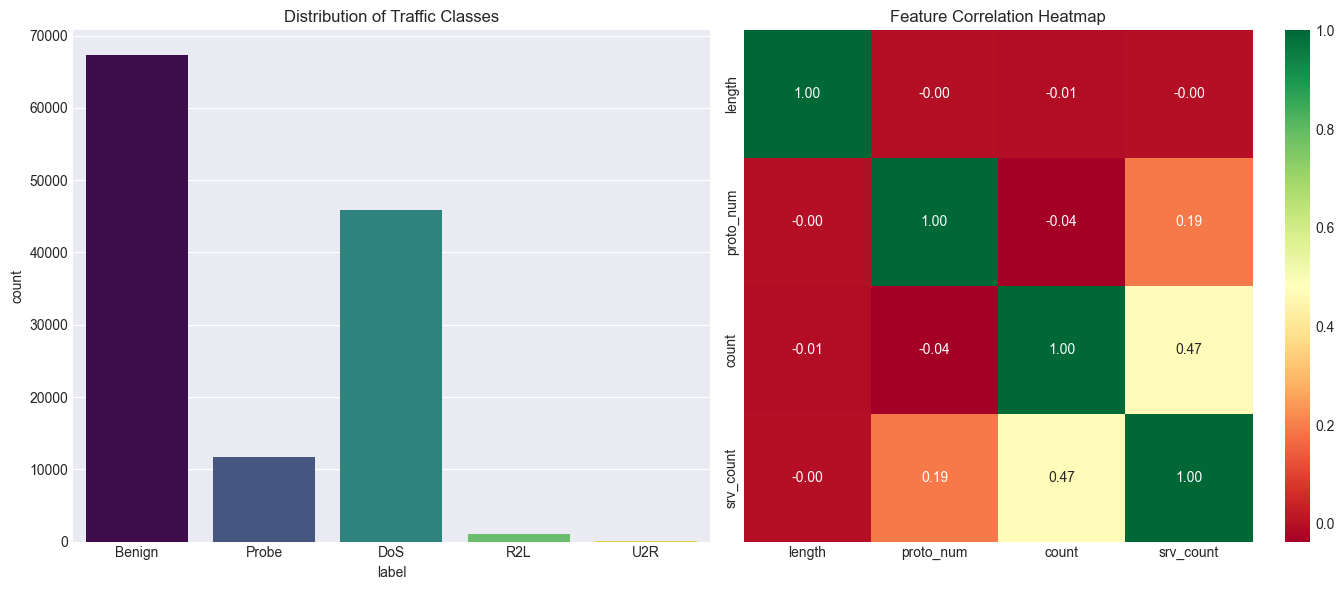

In [34]:
plt.figure(figsize=(14, 6))

# Class Distribution Bar Chart
plt.subplot(1, 2, 1)
sns.countplot(x=y, hue=y, palette="viridis", legend=False)
plt.title("Distribution of Traffic Classes")
plt.xticks(ticks=[0,1,2,3,4], labels=["Benign", "Probe", "DoS", "R2L", "U2R"])

# Feature Correlation Matrix
plt.subplot(1, 2, 2)
sns.heatmap(X.corr(), annot=True, cmap='RdYlGn', fmt='.2f')
plt.title("Feature Correlation Heatmap")

plt.tight_layout()
plt.show()

Cross-Validation (Stability Test)

In [35]:
# Testing model stability
rf_temp = RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=42)
cv_scores = cross_val_score(rf_temp, X, y, cv=5)

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Stability Accuracy: {np.mean(cv_scores) * 100:.2f}%")
print(f"Standard Deviation: {np.std(cv_scores):.4f}")

Cross-Validation Scores: [0.95737249 0.95594364 0.95511014 0.95669604 0.95844249]
Mean Stability Accuracy: 95.67%
Standard Deviation: 0.0011


Final Model Training & Accuracy Analysis

Training Random Forest with Balanced Class Weights...


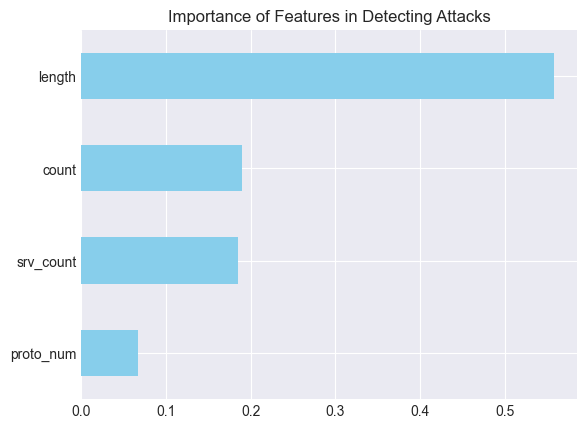

In [36]:
# Split: 80% Training, 20% Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training Random Forest with Balanced Class Weights...")
# class_weight='balanced' ensures rare attacks (U2R/R2L) are prioritized
rf_clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_clf.fit(X_train, y_train)

# Visualize Feature Importance
importances = pd.Series(rf_clf.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', color='skyblue')
plt.title("Importance of Features in Detecting Attacks")
plt.show()

Evaluate Accuracy

In [37]:
y_pred = rf_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"\n✅ Final Model Testing Accuracy: {acc * 100:.2f}%")


✅ Final Model Testing Accuracy: 95.76%


Performance Metrics & Confusion Matrix


--- Classification Report ---
              precision    recall  f1-score   support

      Benign       1.00      0.95      0.97     13422
       Probe       0.77      0.95      0.85      2357
         DoS       0.98      0.97      0.98      9181
         R2L       0.62      0.88      0.72       224
         U2R       0.03      0.18      0.05        11

    accuracy                           0.96     25195
   macro avg       0.68      0.79      0.72     25195
weighted avg       0.97      0.96      0.96     25195



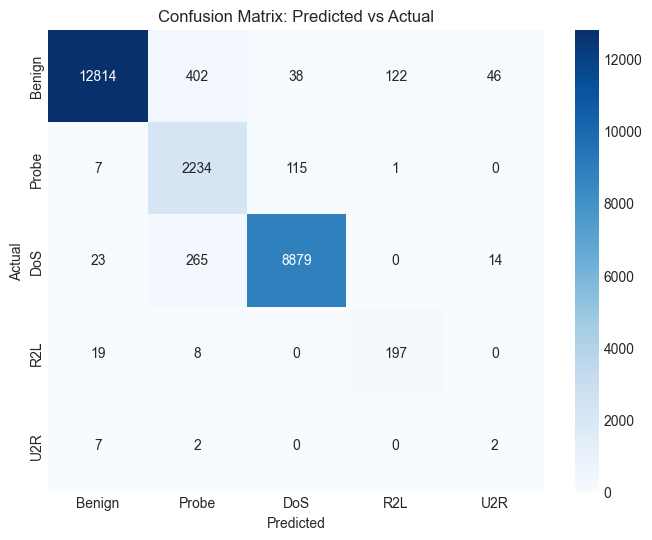

In [38]:
y_pred = rf_clf.predict(X_test)
target_names = ["Benign", "Probe", "DoS", "R2L", "U2R"]

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=target_names))

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix: Predicted vs Actual')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Final Model Export

In [39]:
joblib.dump(rf_clf, 'multiclass_nids.pkl')
print("✅ Success! 'multiclass_nids.pkl' is ready.")
print("You can now run 'python app.py' to start your live dashboard.")

✅ Success! 'multiclass_nids.pkl' is ready.
You can now run 'python app.py' to start your live dashboard.
